In [92]:
# import all modules 
import pandas as pd 
import numpy as np 
import sqlite3 
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from Tools.conversation import start_end_customers_filter
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 

#### 1. connect to the database 

In [3]:
con = sqlite3.connect('../../database/database(620).db')

In [104]:
query1 = """
    SELECT c.id_1, c.id_2, c.id_3, c.id_4, c.id_5, c.id_6, c.id_7, 
    c.airline_id, c.airline_name, c.conversation_opener, g.timestamp_ms
    FROM conversation as c, general_tweets as g
    WHERE g.id == c.id_1
"""
df = pd.read_sql_query(query1, con)

In [105]:
# df = df[df_all.airline_name=='KLM']
df = df.rename(columns={'timestamp_ms' : 'conversation_time'})

In [6]:
query2 = """SELECT id, sentiment_score FROM sentiment_table"""
df_sentiment = pd.read_sql_query(query2, con)

In [7]:
query3 = """SELECT id, timestamp_ms FROM general_tweets"""
df_timestamp = pd.read_sql_query(query3, con)

In [33]:
df_timestamp['timestamp_ms'] = pd.to_datetime(df_timestamp.timestamp_ms)

#### 2. get mean reply time 

In [106]:
# get timestamp for each tweet in each conversation
lst = ['id_1', 'id_2', 'id_3', 'id_4', 'id_5', 'id_6', 'id_7']
suffixes = ['_0', '_1', '_2', '_3', '_4', '_5', '_6' , '_7']
for idx in range(len(lst)):
    df = df.merge(right=df_timestamp, left_on=lst[idx], right_on='id', how='left', suffixes=(suffixes[idx], suffixes[idx + 1]))
    df.drop(columns='id', inplace=True)

In [107]:
df.rename(columns={'timestamp_ms' : 'timestamp_ms_7'}, inplace=True)

In [108]:
# get mean reply time for each row 
lst = []
for idx, row in df.iterrows():
    reply_time = []
    if row.conversation_opener == 'airline':
        reply_time.append((row.timestamp_ms_3 - row.timestamp_ms_2).seconds)
        reply_time.append((row.timestamp_ms_5 - row.timestamp_ms_4).seconds)
        reply_time.append((row.timestamp_ms_7 - row.timestamp_ms_6).seconds)
        reply_time = pd.Series(reply_time).dropna()
        mean_rep = sum(reply_time)/len(reply_time)
        lst.append(mean_rep)
    else:
        reply_time.append((row.timestamp_ms_2 - row.timestamp_ms_1).seconds)
        reply_time.append((row.timestamp_ms_4 - row.timestamp_ms_3).seconds)
        reply_time.append((row.timestamp_ms_6 - row.timestamp_ms_5).seconds)
        reply_time = pd.Series(reply_time).dropna()
        mean_rep = sum(reply_time)/len(reply_time)
        lst.append(mean_rep)

In [109]:
df['mean_reply_time'] = lst

#### 3. get the sentiment change score 

In [110]:
df = pd.concat([start_end_customers_filter(df), 
                df[['conversation_opener', 'conversation_time', 'airline_id', 'airline_name', 'mean_reply_time']].reset_index(drop=True)], 
               axis=1)

In [111]:
# fix the datatype
df['conversation_time'] = pd.to_datetime(df.conversation_time)
df_sentiment = df_sentiment.astype({
    'sentiment_score' : 'float64'
})

In [112]:
# get the sentiment score for open
df = df.merge(df_sentiment, left_on='open', right_on='id').drop(columns='id')
df.shape

(63707, 8)

In [113]:
# get the sentiment score for close 
df = df.merge(df_sentiment, left_on='close', right_on='id', suffixes=('_open', '_close')).drop(columns='id')
df.shape

(62015, 9)

In [114]:
df['sentiment_change'] = df['sentiment_score_close'] - df['sentiment_score_open']

In [115]:
df['positive'] = df['sentiment_change'] > 0

#### 4. filter by timestamp (depend on the teacher)

In [84]:
df_all = df.copy()

In [26]:
# change string timestamp_ms back to Timestamp object and rename column
df_all['conversation_time'] = pd.to_datetime(df_all.conversation_time)

In [27]:
# add attributes month and year 
month = []
year = []
for idx, row in df_all.iterrows():
    month.append(row.conversation_time.month)
    year.append(row.conversation_time.year)
df_all['month'] = month
df_all['year'] = year

In [29]:
df_all.groupby(['year', 'month']).count().index

MultiIndex([(2019,  5),
            (2019,  6),
            (2019,  7),
            (2019,  8),
            (2019,  9),
            (2019, 10),
            (2019, 11),
            (2019, 12),
            (2020,  1),
            (2020,  2),
            (2020,  3)],
           names=['year', 'month'])

In [110]:
# example teacher on January 2019
n_month = 9
n_year = 2019
df = all_df[(all_df.month==n_month) & (all_df.year==n_year)].copy()
df.shape

(7472, 12)

#### 5. plotting

In [121]:
# standardize variables 
p = df[['mean_reply_time', 'sentiment_change']]
df_new = (p - p.mean())/p.std()

In [128]:
df_new = df_new[(df_new.sentiment_change < 3) & (df_new.sentiment_change > -3)]
df_new = df_new[(df_new.mean_reply_time < 3) & (df_new.mean_reply_time > -3)]

In [144]:
final = df_new.sample(1000)

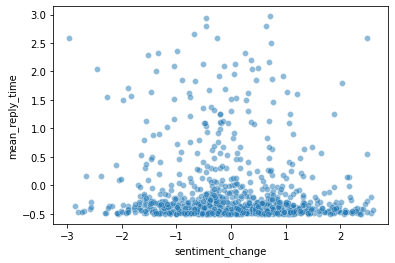

In [143]:
ax = sns.scatterplot(data=final, x='sentiment_change', y='mean_reply_time', alpha=0.5)

(0.0, 600.0)

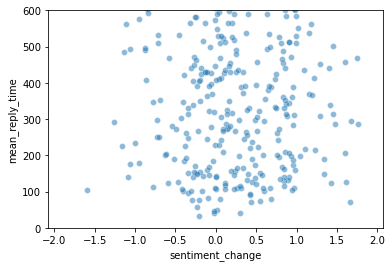

In [147]:
ax = sns.scatterplot(data=df.sample(1000), x='sentiment_change', y='mean_reply_time', alpha=0.5)
ax.set_ylim(0, 600)

In [166]:
# correlation coefficient 
np.corrcoef(df_new['sentiment_change'], df_new['mean_reply_time'])

array([[ 1.        , -0.01263565],
       [-0.01263565,  1.        ]])

<AxesSubplot:xlabel='sentiment_change', ylabel='mean_reply_time'>

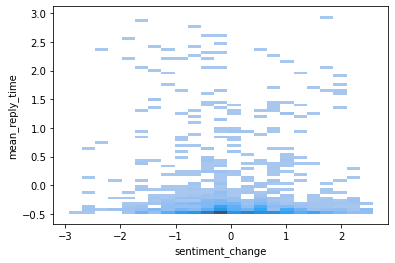

In [170]:
# make histogram
sns.histplot(data=df_new.sample(1000), x='sentiment_change', y='mean_reply_time')